**Use Tensorflow version 1 for using coreml tools**

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


**Import required libraries**

In [2]:
from keras.layers import Input, Dense, Conv2D,  add, AveragePooling2D, \
    Activation, MaxPool2D, Flatten, Dropout,BatchNormalization
from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adamax
import os,math
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2

Using TensorFlow backend.


**Mount Google Drive**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


**Define hyper-parameters**

In [4]:
#training data and validation data directories
train_data_dir = "gdrive/My Drive/ACV Project/train"
validation_data_dir = "gdrive/My Drive/ACV Project/test"

#Path to save training and best model weights
path_train = "gdrive/My Drive/ACV Project/modelWeights/ACV_train.h5"
path_best = "gdrive/My Drive/ACV Project/modelWeights/ACV_best.h5"

#path to save coreml models
path_coreML = "gdrive/My Drive/ACV Project/modelWeights/resnet_train_15.mlmodel"
path_classLabels = "gdrive/My Drive/ACV Project/modelWeights/labl.txt"

batch_size=16
image_size = (224, 224)
nb_epoch = 1000

#8 output classes corresponding to 8 sides of the car
NUMBER_OF_CLASSES = 8

**Build Resnet34 like model**

Helper function to build skip connections

In [5]:
def resnetBuilder(l, filters):
    x = l

    #Add 2 new layers
    l = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(l)
    l = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(l)
    l = BatchNormalization()(l)
    l = Dropout(0.5)(l)

    #Add the initial input to form skip connections
    x = Conv2D(filters=filters, kernel_size=(1,1), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = add([x,l])
    x = Activation('relu')(x)

    return x 

Main module for creating Resnet34 like model

In [6]:
def createResnetModel():
    #Input is RGB image of size 224x224
    input = Input(shape=(224, 224, 3))
    l = Conv2D(filters=64, kernel_size=(7,7), padding="same")(input)
    l = Activation('relu')(l)
    l = MaxPool2D(pool_size=(3,3))(l)

    #Use helper function to build model
    l = resnetBuilder(l, 64)
    l = resnetBuilder(l, 64)
    l = resnetBuilder(l, 64)
    l = resnetBuilder(l, 128)
    l = resnetBuilder(l, 128)
    l = resnetBuilder(l, 128)
    l = resnetBuilder(l, 128)
    l = resnetBuilder(l, 256)
    l = resnetBuilder(l, 256)
    l = resnetBuilder(l, 256)
    l = resnetBuilder(l, 256)    
    l = resnetBuilder(l, 256)
    l = resnetBuilder(l, 256)
    l = resnetBuilder(l, 512)
    l = resnetBuilder(l, 512)
    l = resnetBuilder(l, 512)

    #AveragePooling and Flatten followed by output layer
    l = AveragePooling2D(pool_size=(8,8))(l)
    l = Flatten()(l)
    output = Dense(NUMBER_OF_CLASSES, activation='softmax')(l)

    model = Model(inputs=input, outputs=output)
    return model

**Compile the model**

In [7]:
def compile_model(compiledModel):
    compiledModel.compile(loss=categorical_crossentropy,
                  optimizer=Adamax(learning_rate=0.0001, decay=1e-06),
                  metrics=['accuracy'])

**Create callback functions**

In [8]:
checkpoint = ModelCheckpoint(path_train, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=200, verbose=1, mode='auto')

**Method to load data and train the model**

In [9]:
def modelFitGenerator(fitModel):
    #load train and validation samples
    num_train_samples = sum([len(files) for r, d, files in os.walk(train_data_dir)])
    num_valid_samples = sum([len(files) for r, d, files in os.walk(validation_data_dir)])

    #calculate train and validation steps
    num_train_steps = math.floor(num_train_samples/batch_size)
    num_valid_steps = math.floor(num_valid_samples/batch_size)
    
    #Code for using data augmentation. 
    #Not using any augmentation parameters currently as it degrades performance.
    train_datagen = ImageDataGenerator( ) 
    #   rotation_range=90,      
    #   horizontal_flip=True,    
    #   vertical_flip=True,
    #   zoom_range=0.4)

    test_datagen = ImageDataGenerator()

    #Access train and validation data for training
    train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=image_size ,
      batch_size=batch_size,
      class_mode='categorical', shuffle=True
    )
    validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=image_size ,
      batch_size=batch_size,
      class_mode='categorical', shuffle=True
    )

    #Train the model using training and validation data
    history = fitModel.fit_generator(
      train_generator,
      steps_per_epoch=num_train_steps//100,#num_train_steps//1000,
      epochs=nb_epoch,
      validation_data=validation_generator,
      validation_steps=num_valid_steps,
      callbacks=[checkpoint, early])

**Create Resnet34 like model and compile.**

In [10]:
model = createResnetModel()
compile_model(model)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 74, 74, 64)   0           activation_1[0][0]               
_________

**Display the model**

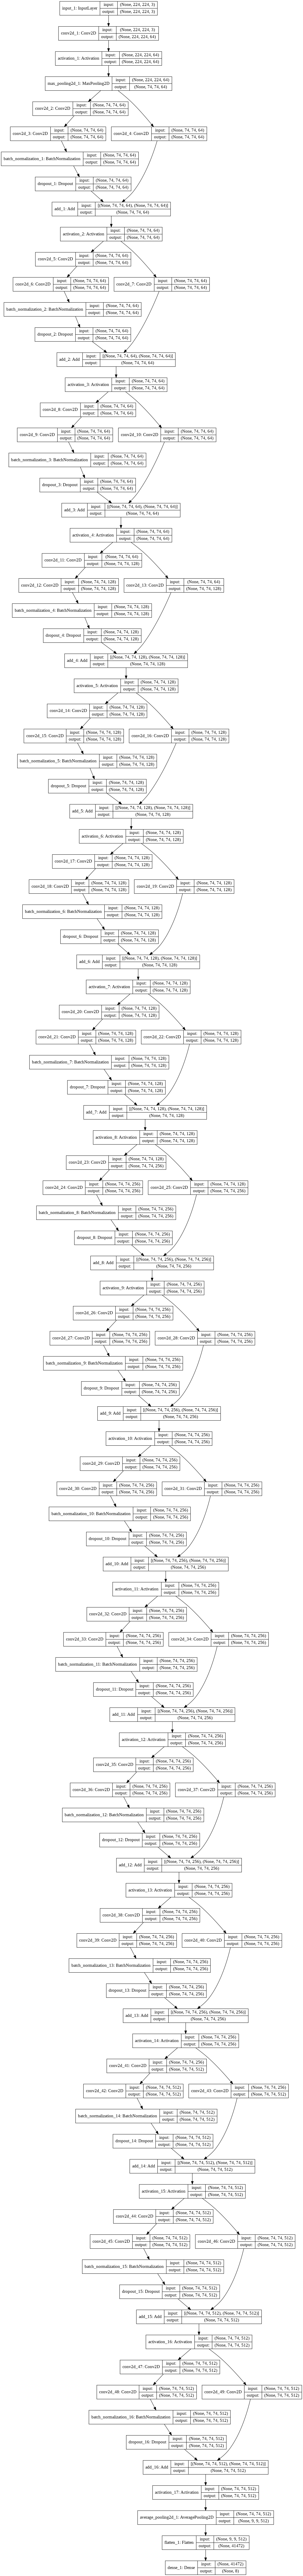

In [11]:
from keras.utils.vis_utils import plot_model
plot_model(model,  show_shapes=True) #to_file="gdrive/My Drive/Colab Notebooks/model.png",

**Load weights, if required. Start training the model.**

In [14]:
model.load_weights(path_best)
modelFitGenerator(model)

Found 100001 images belonging to 8 classes.
Found 6825 images belonging to 8 classes.
Epoch 1/1000
62/62 [==============================] - 401s 6s/step - loss: 5.5060 - accuracy: 0.9607 - val_loss: 6.3523 - val_accuracy: 0.7660

Epoch 00001: val_accuracy did not improve from 0.95741
Epoch 2/1000
62/62 [==============================] - 357s 6s/step - loss: 5.4348 - accuracy: 0.9677 - val_loss: 5.3829 - val_accuracy: 0.9643

Epoch 00002: val_accuracy improved from 0.95741 to 0.96431, saving model to gdrive/My Drive/ACV Project/modelWeights/ACV_train.h5
Epoch 3/1000
62/62 [==============================] - 352s 6s/step - loss: 5.4595 - accuracy: 0.9617 - val_loss: 5.3223 - val_accuracy: 0.9633

Epoch 00003: val_accuracy did not improve from 0.96431
Epoch 4/1000
62/62 [==============================] - 351s 6s/step - loss: 5.4609 - accuracy: 0.9607 - val_loss: 5.3236 - val_accuracy: 0.9581

Epoch 00004: val_accuracy did not improve from 0.96431
Epoch 5/1000
62/62 [=======================

KeyboardInterrupt: ignored

**Install Coremltools.**

In [15]:
!pip install -U coremltools 

Requirement already up-to-date: coremltools in /usr/local/lib/python3.6/dist-packages (4.0)


**Function to create coreMLModel**

In [16]:
import coremltools

def saveCoreMLModel(kerasModel):
    coreml_model = coremltools.converters.keras.convert(kerasModel,
                                                    input_names=['input'],
                                                    output_names=['probs'],
                                                    image_input_names='input',
                                                    predicted_feature_name='predictedAngle',
                                                    class_labels = path_classLabels)
    coreml_model.save(path_coreML) 
    print('CoreML model saved')

model.load_weights(path_best)
saveCoreMLModel(model)

0 : input_1, <keras.engine.input_layer.InputLayer object at 0x7f4ed28809b0>
1 : conv2d_1, <keras.layers.convolutional.Conv2D object at 0x7f4f20af25f8>
2 : activation_1, <keras.layers.core.Activation object at 0x7f4ed2883160>
3 : max_pooling2d_1, <keras.layers.pooling.MaxPooling2D object at 0x7f4ed2883390>
4 : conv2d_2, <keras.layers.convolutional.Conv2D object at 0x7f4ed2883668>
5 : conv2d_2__activation__, <keras.layers.core.Activation object at 0x7f4e58bbd7b8>
6 : conv2d_3, <keras.layers.convolutional.Conv2D object at 0x7f4f20ccbe10>
7 : conv2d_3__activation__, <keras.layers.core.Activation object at 0x7f4ed28f6ba8>
8 : batch_normalization_1, <keras.layers.normalization.BatchNormalization object at 0x7f4ed27e1048>
9 : conv2d_4, <keras.layers.convolutional.Conv2D object at 0x7f4ec02c0c88>
10 : conv2d_4__activation__, <keras.layers.core.Activation object at 0x7f4ed28f6cf8>
11 : add_1, <keras.layers.merge.Add object at 0x7f4ec02f5e80>
12 : activation_2, <keras.layers.core.Activation obje